Preparación del entorno

In [9]:
import numpy as np
import joblib
from envs.v2.multi_step_limited_attack_env import AttackEnvLimitedMultiStep
from stable_baselines3.common.callbacks import BaseCallback
from envs.v2.defender_env import DefenderEnv
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

Funciones auxiliares

In [1]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class DefenderLoggerCallback(BaseCallback):
    def __init__(self, log_freq: int = 1000, verbose: int = 0):
        super().__init__(verbose)
        self.log_freq = log_freq
        self.episode_count = 0

        # Buffers por ventana (1000 episodios)
        self.rewards_buffer = []          # Todas las recompensas de los pasos
        self.threshold_buffer = []        # Todos los thresholds vistos (valor umbral para decidir ataque)
        self.p_attack_buffer = []         # Todas las p_attack vistas (probabilidad de que la muestra sea de ataque según el modelo)

        # Contadores por ventana para calcular dection rate y false positive rate
        self.attack_count = 0             # Número de muestras de ataque
        self.tp_count = 0                 # Número de ataques correctamente detectados
        self.normal_count = 0             # Número de muestras normales
        self.fp_count = 0                 # Número de falsos positivos (normales mal clasificados como ataques) 

        # Históricos completos para graficar
        self.history_episodes = []
        self.history_mean_reward = []
        self.history_detection_rate = []      # Ratio de verdaderos positivos tp (numeros de ataques detectados) / ataques totales
        self.history_false_positive_rate = [] # Ratio de falsos positivos fp (normales mal clasificados) / normales totales
        self.history_mean_threshold = []
        self.history_mean_p_attack = []

    def _on_step(self) -> bool:
       
        # Extraemos la información relevante del entorno
        infos = self.locals["infos"]
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]

        # Itreramos sobre la informacióm, recompensa y done de cada entorno en cada paso
        for info, r, done in zip(infos, rewards, dones):

            # Guardamos recompensa de este paso
            self.rewards_buffer.append(float(r))

            # Extraemos info del entorno si está disponible
            if isinstance(info, dict):

                # Guardamos threshold
                if "threshold" in info:
                    self.threshold_buffer.append(float(info["threshold"]))

                # Guardamos p_attack
                if "p_attack" in info:
                    self.p_attack_buffer.append(float(info["p_attack"]))

                # Si tenemos la etiqueta real y la predicción, actualizamos contadores
                if "y_sample" in info and "pred" in info:
                    y = int(info["y_sample"])   # 0 = normal, 1 = ataque
                    pred = int(info["pred"])    # 0 = normal, 1 = ataque

                    # Si es ataque o normal, actualizamos contadores
                    if y == 1:
                        self.attack_count += 1
                        if pred == 1:
                            self.tp_count += 1
                    else:
                        self.normal_count += 1
                        if pred == 1:
                            self.fp_count += 1

            # Si termina episodio
            if done:
                self.episode_count += 1

                # Cada log_freq episodios, calculamos métricas y reseteamos buffers
                if self.episode_count > 0 and self.episode_count % self.log_freq == 0:

                    # Reward media por paso en la ventana
                    mean_reward = np.mean(self.rewards_buffer) if self.rewards_buffer else 0.0

                    # Tasa de detección (TPR) y tasa de falsos positivos (FPR)
                    detection_rate = (self.tp_count / self.attack_count) if self.attack_count > 0 else 0.0
                    false_positive_rate = (self.fp_count / self.normal_count) if self.normal_count > 0 else 0.0

                    # Stats de threshold y p_attack
                    mean_threshold = np.mean(self.threshold_buffer) if self.threshold_buffer else 0.0
                    mean_p_attack = np.mean(self.p_attack_buffer) if self.p_attack_buffer else 0.0

                    # Guardamos en históricos
                    self.history_episodes.append(self.episode_count)
                    self.history_mean_reward.append(mean_reward)
                    self.history_detection_rate.append(detection_rate)
                    self.history_false_positive_rate.append(false_positive_rate)
                    self.history_mean_threshold.append(mean_threshold)
                    self.history_mean_p_attack.append(mean_p_attack)

                    # Log por consola
                    print(
                        f"[DefenderLogger] Episodios: {self.episode_count:6d} | "
                        f"Reward media: {mean_reward: .3f} | "
                        f"TPR (detección ataques): {detection_rate*100:5.1f}% | "
                        f"FPR (falsos positivos): {false_positive_rate*100:5.1f}% | "
                        f"threshold medio: {mean_threshold: .3f} | "
                        f"p_attack media: {mean_p_attack: .3f}"
                    )

                    # Reseteamos buffers para la siguiente ventana
                    self.rewards_buffer.clear()
                    self.threshold_buffer.clear()
                    self.p_attack_buffer.clear()
                    self.attack_count = 0
                    self.tp_count = 0
                    self.normal_count = 0
                    self.fp_count = 0

        return True

In [ ]:
# Función de evaluación del defensor
def evaluate_defender(model, env, n_episodes=500):

    # Inicializamos contadores
    total_reward = 0.0
    total_steps = 0
    attack_count = 0
    detected_attacks = 0   # TP
    normal_count = 0
    false_positives = 0    # FP
    thresholds = []
    p_attacks = []

    # Reset inicial del entorno vectorizado
    obs = env.reset()

    # Iteramos sobre el número de episodios a evaluar
    for _ in range(n_episodes):

        # Variables de control de finalización del episodio
        done = False
        truncated = False

        # Mientras no termine el episodio
        while not (done or truncated):
            # Acción del modelo (determinista en evaluación)
            action, _ = model.predict(obs, deterministic=True)

            # Step en el entorno vectorizado
            obs, rewards, dones, infos = env.step(action)

            # Cargamos la información relevante del primer entorno
            r = float(rewards[0])
            info0 = infos[0]
            done = bool(dones[0])

            # Parche para gym
            truncated = info0.get("terminal_observation") is not None if False else False

            # Acumulamos recompensa y pasos
            total_reward += r
            total_steps += 1

            # Extraemos threshold y p_attack si están
            if "threshold" in info0:
                thresholds.append(float(info0["threshold"]))
            if "p_attack" in info0:
                p_attacks.append(float(info0["p_attack"]))

            # Extraemos y_sample y pred para TP / FP
            if "y_sample" in info0 and "pred" in info0:
                y = int(info0["y_sample"])   # 0 = normal, 1 = ataque
                pred = int(info0["pred"])    # 0 = normal, 1 = ataque

                if y == 1:
                    attack_count += 1
                    if pred == 1:
                        detected_attacks += 1
                else:
                    normal_count += 1
                    if pred == 1:
                        false_positives += 1

            # Si quieres contemplar truncados adicionales (parche estilo gym):
            # 

        # Reset para siguiente episodio
        obs = env.reset()

    # Cálculo de métricas
    mean_reward = total_reward / total_steps if total_steps > 0 else 0.0
    detection_rate = detected_attacks / attack_count if attack_count > 0 else 0.0
    false_positive_rate = false_positives / normal_count if normal_count > 0 else 0.0
    mean_threshold = float(np.mean(thresholds)) if thresholds else None
    mean_p_attack = float(np.mean(p_attacks)) if p_attacks else None

    return detection_rate, false_positive_rate, mean_reward, mean_threshold, mean_p_attack


In [26]:
import numpy as np

def sample_defender_vec(model, venv, n_episodes=300, max_steps=20):
    """
    Muestrea episodios usando un entorno vectorizado (VecEnv) con n_envs=1.
    Asume que en infos[0] vienen las claves:
      - "x_orig": punto original del ataque
      - "x_adv": punto adversarial final
      - "pred": 1 si detectado, 0 si evade
      - opcional: "step_count"
    """

    xs_orig = []
    xs_adv = []
    detections = []  # 1 = detectado, 0 = evade

    for _ in range(n_episodes):
        # RESET en VecEnv: devuelve solo obs (no info)
        obs = venv.reset()
        x_orig_ep = None

        for _ in range(max_steps):
            # model.predict ya se encarga del batching para VecEnv
            action, _ = model.predict(obs, deterministic=True)

            obs, rewards, dones, infos = venv.step(action)

            # infos es lista de dicts, uno por env. Usamos el primero (n_envs=1)
            info0 = infos[0]

            # Guardamos el ataque original en el primer step donde aparezca
            if x_orig_ep is None and "x_orig" in info0:
                x_orig_ep = info0["x_orig"]

            # done puede ser array/list → nos quedamos con el primero
            done0 = dones[0] if isinstance(dones, (list, np.ndarray)) else dones
            step_count = info0.get("step_count", 0)

            is_last = bool(done0) or (step_count >= max_steps)

            if is_last:
                # Esperamos que info0 tenga x_adv y pred en el último paso
                x_adv_final = info0["x_adv"]
                pred_final = info0["pred"]  # 1 = detectado, 0 = evade

                xs_orig.append(x_orig_ep)
                xs_adv.append(x_adv_final)
                detections.append(pred_final)
                break

    return np.array(xs_orig), np.array(xs_adv), np.array(detections)


Creación del área de trabajo

In [3]:
# Cargar datos
data = np.load("../../data/v2/synthetic_2d.npz")
X_train, X_test = data["X_train"], data["X_test"]
y_train, y_test = data["y_train"], data["y_test"]

# Cargamos las muestras normales y de ataque
normal_samples = X_train[y_train == 0]
attack_samples = X_train[y_train == 1]

# Imprimir formas de los datos cargados
print("Normal:", normal_samples.shape, "Attack:", attack_samples.shape)

Normal: (800, 2) Attack: (800, 2)


In [4]:
# Cargar clasificador clásico
clf = joblib.load("../../classifiers/v2/logreg_synthetic_2d.joblib")

# Crear AttackEnvLimitedMultiStep igual que lo hicmos para entrenar SAC
attack_env = AttackEnvLimitedMultiStep(
    attack_samples=attack_samples,
    clf=clf,
    threshold=0.5,   # Este threshold solo afecta a la reward del atacante, no al defensor
    epsilon=0.7,
    penalty=0.01,
    max_steps=5,
)

# Cargar modelo SAC atacante
attacker_model = SAC.load("../../agents/v2/sac_attacker_limited_multistep")

In [5]:
# Función para crear el entorno del defensor
def make_defender_env():
    return DefenderEnv(
        normal_samples=normal_samples,
        attack_env=attack_env,
        attacker_model=attacker_model,
        init_threshold=0.5,
        delta_max=0.1,
        min_threshold=0.05,
        max_threshold=0.95,
        attack_prob=0.5,        # mitad normal / mitad ataque
        episode_length=50,
        extremal_penalty=0.1,
    )

# Crear entorno vectorizado para el defensor
venv_def = DummyVecEnv([make_defender_env])

Entrenamiento del agente PPO Defender

In [7]:
# Arquitectura de la red neuronal para el defensor
policy_kwargs = dict(net_arch=[128, 128])

defender_model = PPO(
    "MlpPolicy",
    venv_def,
    verbose=0,
    learning_rate=3e-4,
    n_steps=2048, # Número de pasos por actualización
    batch_size=64, # Grupos en los que se divide cada actualización
    policy_kwargs=policy_kwargs,
)

# Creación de callback personalizado para logging
defender_callback = DefenderLoggerCallback(log_freq=100)

# Entrenamiento del modelo del defensor
defender_model.learn(total_timesteps=100_000, callback=defender_callback)

# Guardar el modelo entrenado del defensor
defender_model.save("../../agents/v2/ppo_defender_threshold")

[DefenderLogger] Episodios:    100 | Reward media:  0.172 | TPR (detección ataques):  41.0% | FPR (falsos positivos):  39.3% | threshold medio:  0.420 | p_attack media:  0.362
[DefenderLogger] Episodios:    200 | Reward media:  0.327 | TPR (detección ataques):  50.7% | FPR (falsos positivos):  47.5% | threshold medio:  0.219 | p_attack media:  0.354
[DefenderLogger] Episodios:    300 | Reward media:  0.346 | TPR (detección ataques):  50.0% | FPR (falsos positivos):  52.2% | threshold medio:  0.174 | p_attack media:  0.358
[DefenderLogger] Episodios:    400 | Reward media:  0.326 | TPR (detección ataques):  51.9% | FPR (falsos positivos):  54.4% | threshold medio:  0.164 | p_attack media:  0.361
[DefenderLogger] Episodios:    500 | Reward media:  0.326 | TPR (detección ataques):  52.9% | FPR (falsos positivos):  54.1% | threshold medio:  0.151 | p_attack media:  0.357
[DefenderLogger] Episodios:    600 | Reward media:  0.341 | TPR (detección ataques):  54.7% | FPR (falsos positivos):  5

Gráficas PPO Defender

In [10]:
# Configuración de estilo
plt.style.use("seaborn-v0_8-whitegrid")

# Datos para graficar
episodes = np.array(defender_callback.history_episodes)

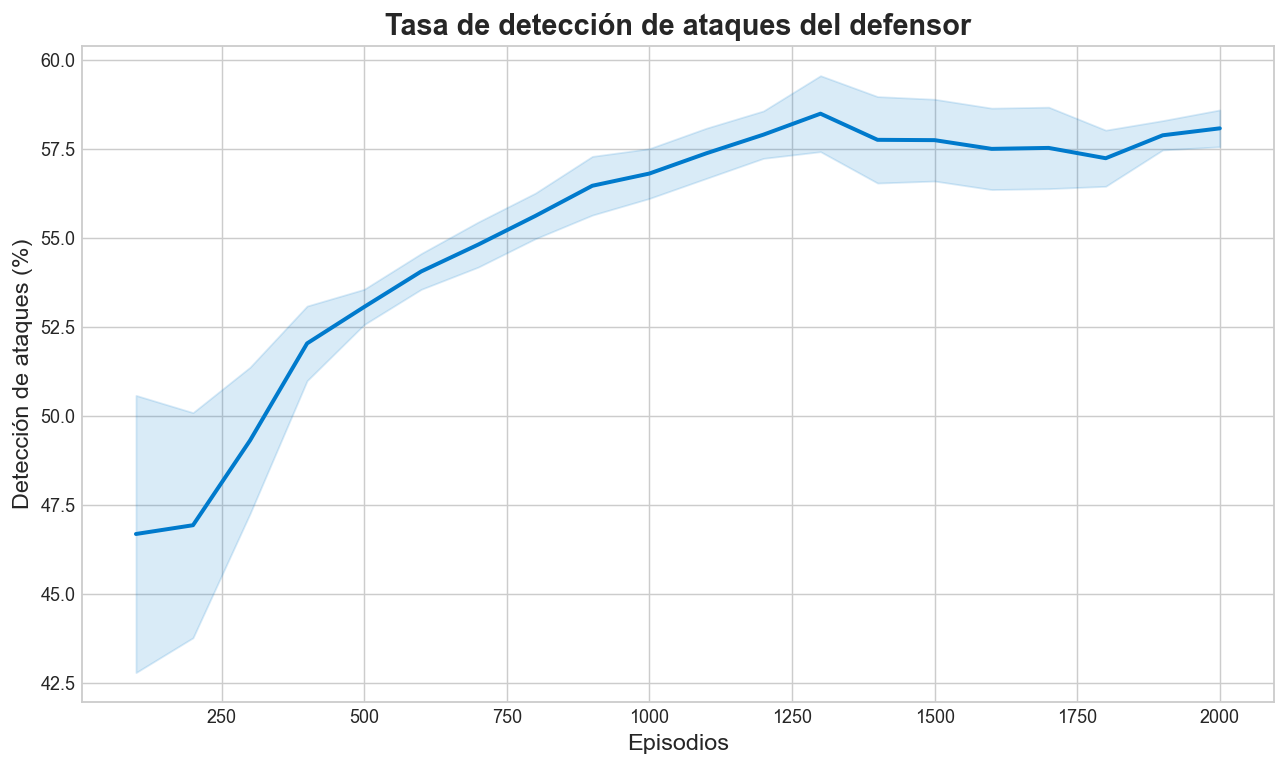

In [11]:
# Gráfico de Tasa de detección de ataques (TPR)
detection_rate = np.array(defender_callback.history_detection_rate) * 100

# Suavizado
window = 5
smooth_detection = uniform_filter1d(detection_rate, size=window)
mean = smooth_detection
std = uniform_filter1d(np.abs(detection_rate - mean), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, mean, linewidth=2.2, color="#007acc")

# Banda difuminada
plt.fill_between(
    episodes,
    mean - std,
    mean + std,
    color="#007acc",
    alpha=0.15
)
plt.title("Tasa de detección de ataques del defensor", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("Detección de ataques (%)", fontsize=13)
plt.tight_layout()
plt.show()


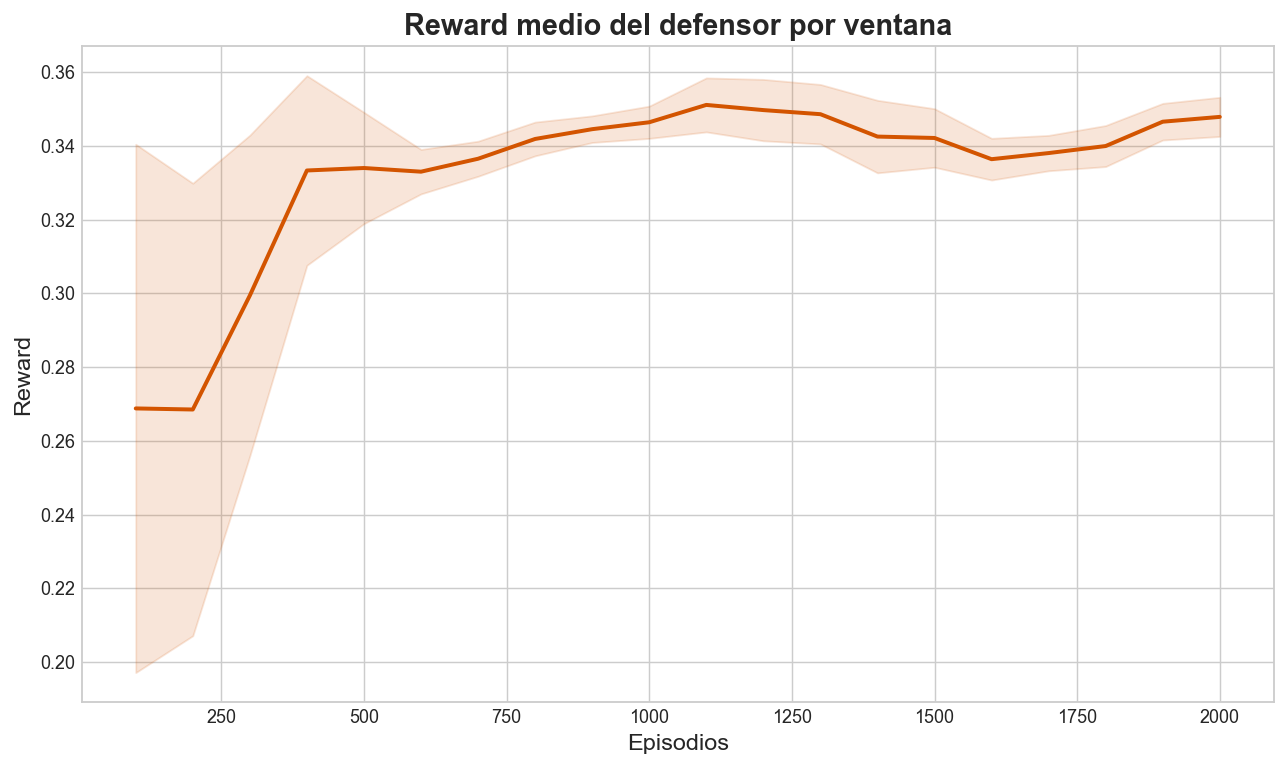

In [12]:
# Reward medio por ventana
mean_reward = np.array(defender_callback.history_mean_reward)

# Suavizado
window = 5
smooth_reward = uniform_filter1d(mean_reward, size=window)

# Desviación estándar local
std_reward = uniform_filter1d(np.abs(mean_reward - smooth_reward), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, smooth_reward, linewidth=2.2, color="#d35400")

# Banda difuminada
plt.fill_between(
    episodes,
    smooth_reward - std_reward,
    smooth_reward + std_reward,
    color="#d35400",
    alpha=0.15
)

plt.title("Reward medio del defensor por ventana", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("Reward", fontsize=13)
plt.tight_layout()
plt.show()

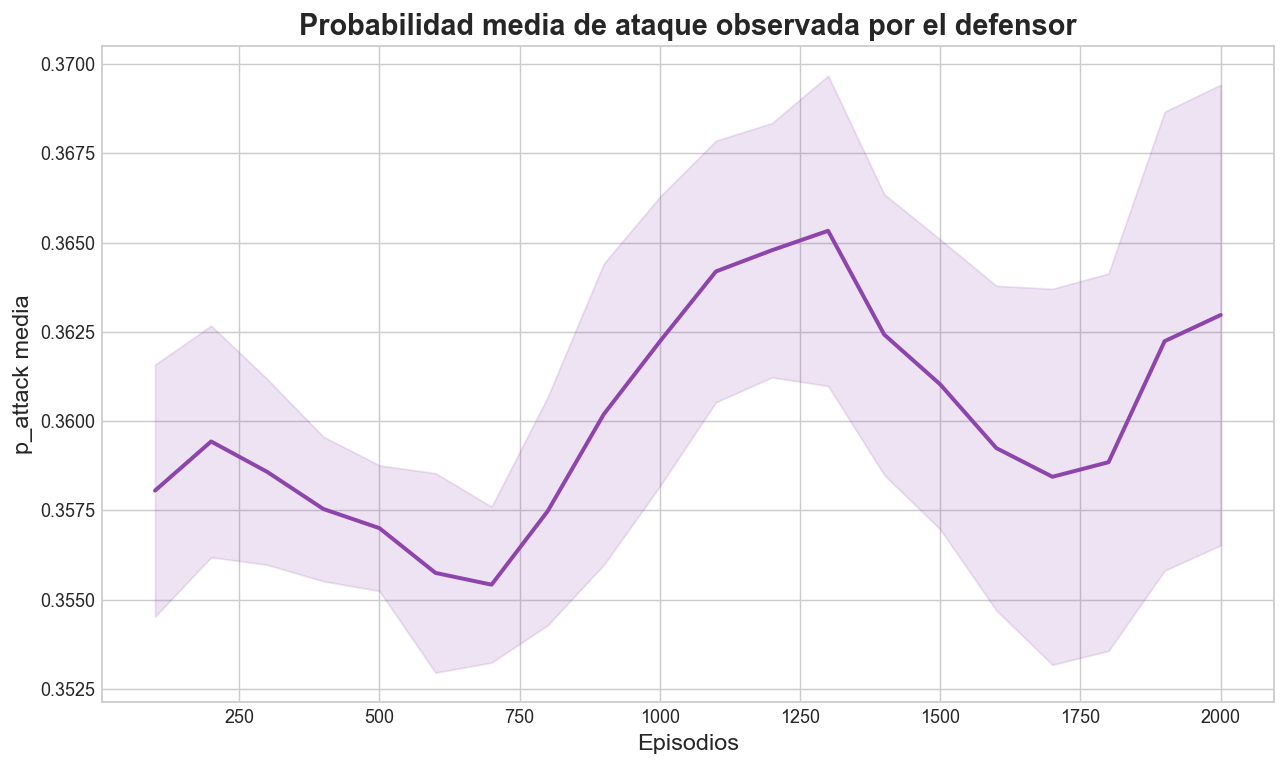

In [13]:
# Probabilidad media de ataque (según el clasificador) que ve el defensor
mean_p_attack = np.array(defender_callback.history_mean_p_attack)

# Suavizado
window = 5
smooth_p_attack = uniform_filter1d(mean_p_attack, size=window)

# Desviación estándar local
std_p_attack = uniform_filter1d(np.abs(mean_p_attack - smooth_p_attack), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, smooth_p_attack, linewidth=2.2, color="#8e44ad")

# Banda difuminada
plt.fill_between(
    episodes,
    smooth_p_attack - std_p_attack,
    smooth_p_attack + std_p_attack,
    color="#8e44ad",
    alpha=0.15
)

plt.title("Probabilidad media de ataque observada por el defensor", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("p_attack media", fontsize=13)
plt.tight_layout()
plt.show()


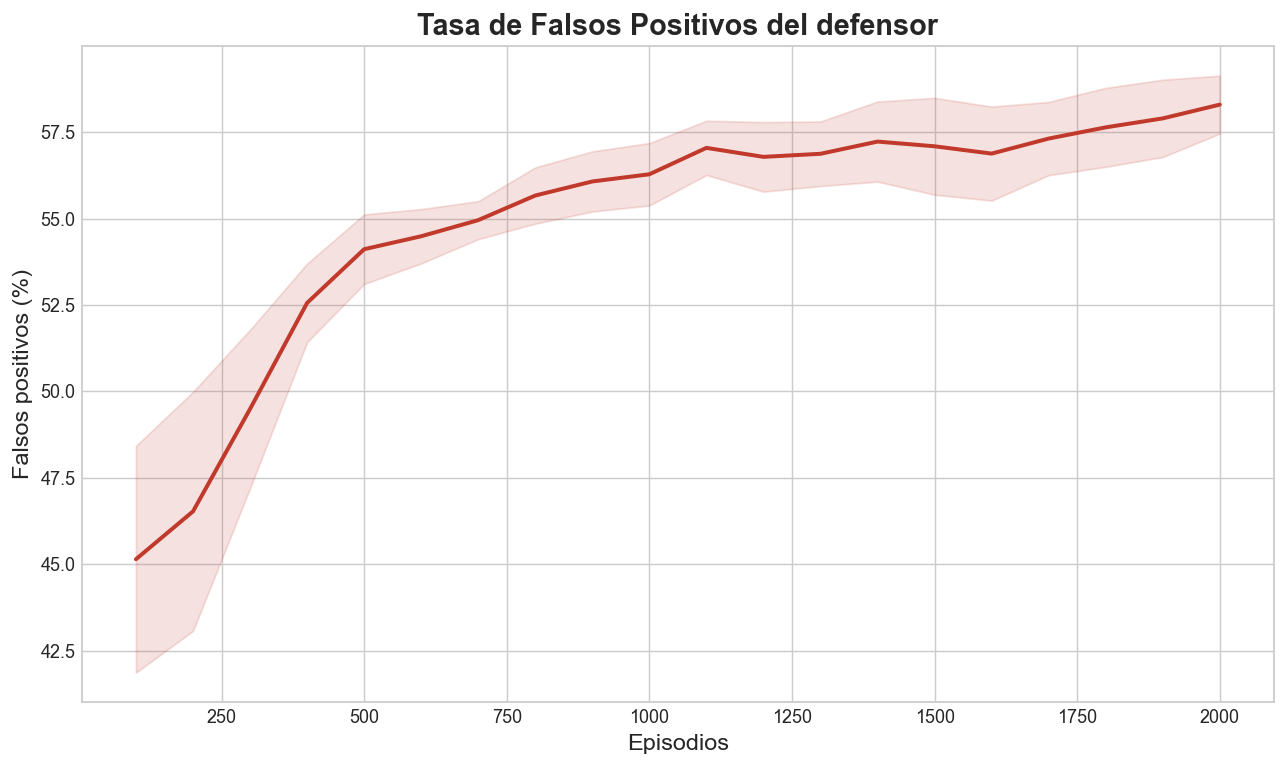

In [14]:
# Tasa de falsos positivos (FPR)
false_positive_rate = np.array(defender_callback.history_false_positive_rate) * 100  # en %

# Suavizado
window = 5
smooth_fpr = uniform_filter1d(false_positive_rate, size=window)

# Desviación estándar local
std_fpr = uniform_filter1d(np.abs(false_positive_rate - smooth_fpr), size=window)

# Configuración del gráfico
plt.figure(figsize=(10, 6), dpi=130)

# Línea suavizada
plt.plot(episodes, smooth_fpr, linewidth=2.2, color="#c0392b")

# Banda difuminada
plt.fill_between(
    episodes,
    smooth_fpr - std_fpr,
    smooth_fpr + std_fpr,
    color="#c0392b",
    alpha=0.15
)

plt.title("Tasa de Falsos Positivos del defensor", fontsize=16, fontweight="bold")
plt.xlabel("Episodios", fontsize=13)
plt.ylabel("Falsos positivos (%)", fontsize=13)
plt.tight_layout()
plt.show()

In [17]:
# Creamos el entorno vectorizado para evaluación
venv_def = DummyVecEnv([make_defender_env])  # ya lo tienes creado

# Cargamos el modelo del defensor entrenado
model_defender = PPO.load("../../agents/v2/ppo_defender_threshold")

# Evaluamos el defensor con 300 episodios
det_rate, fpr, mean_reward, mean_th, mean_p = evaluate_defender(model_defender, venv_def, n_episodes=300)

# Sacamos los resultados por consola
print(f"Tasa de detección (TPR):           {det_rate*100:.3f}%") # De todos los ataques, cuántos detecta
print(f"Tasa de falsos positivos (FPR):    {fpr*100:.3f}%") # De todos los normales, cuántos clasifica mal como ataques
print(f"Reward medio por paso:            {mean_reward:.3f}")
print(f"Threshold medio:                  {mean_th:.3f}")
print(f"Probabilidad media de ataque:     {mean_p:.3f}") # Probabilidad media de que las muestras sean ataques según el clasificador

Tasa de detección (TPR):           60.378%
Tasa de falsos positivos (FPR):    61.095%
Reward medio por paso:            0.328
Threshold medio:                  0.066
Probabilidad media de ataque:     0.360


In [28]:
# Muestreamos 300 episodios del defensor
xs_orig, xs_adv, detections = sample_defender_vec(model_defender, venv_def, n_episodes=300)

# Configuración del gráfico
plt.figure(figsize=(6, 6))

# Puntos originales (ataques) — azul claro
plt.scatter(xs_orig[:, 0], xs_orig[:, 1], alpha=0.3, label="Original")

# Ataques detectados — verde
mask_detected = detections == 1
plt.scatter(xs_adv[mask_detected, 0], xs_adv[mask_detected, 1],
            alpha=0.7, color="green", label="Detectado")

# Ataques que evaden — rojo
mask_evade = detections == 0
plt.scatter(xs_adv[mask_evade, 0], xs_adv[mask_evade, 1],
            alpha=0.7, color="red", label="Evade (fallo del defensor)")
plt.legend()
plt.grid(True)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Resultados del agente DEFENSOR")
plt.show()

KeyError: 'x_adv'

Entender coo funciona (precvison con el nuevo)
metricaq precciosn ataacten